# COURSE:   PGP [AI&ML]

## Learner :  Chaitanya Kumar Battula
## Module  : Machine Learning
## Topic   : Time Series_IMF Commodity Price Forecast¶

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('zinc_prices_IMF.csv')
print(df.head())
df.describe()

       Date   Price
0  1-Jan-80  773.82
1  1-Feb-80  868.62
2  1-Mar-80  740.75
3  1-Apr-80  707.68
4  1-May-80  701.07


,Price
count,434.000000
mean,1362.338594
std,677.071321
min,597.450000
25%,875.355000
50%,1088.875000
75%,1742.052500
max,4381.450000


In [3]:
df.loc[:,'Date'] = pd.to_datetime(df['Date'])

In [4]:
df.set_index('Date', inplace=True)

In [5]:
df.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01'],
              dtype='datetime64[ns]', name='Date', length=434, freq=None)

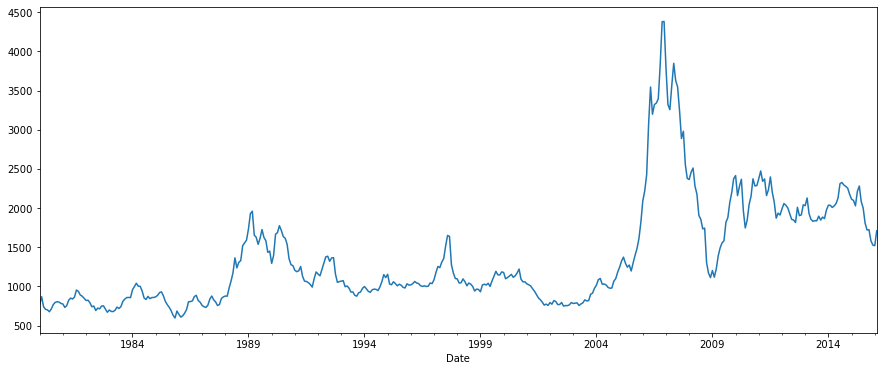

In [6]:
ts = df['Price']
ts.plot()

In [7]:
ts_log = np.log(ts)

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

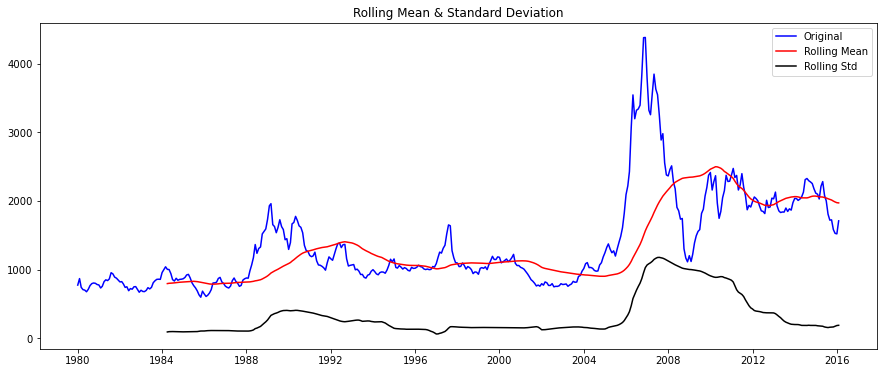

Results of Dickey-Fuller Test:
Test Statistic                  -3.139601
p-value                          0.023758
#Lags Used                       7.000000
Number of Observations Used    426.000000
Critical Value (1%)             -3.445794
Critical Value (5%)             -2.868349
Critical Value (10%)            -2.570397
dtype: float64


In [9]:
test_stationarity(df['Price'])

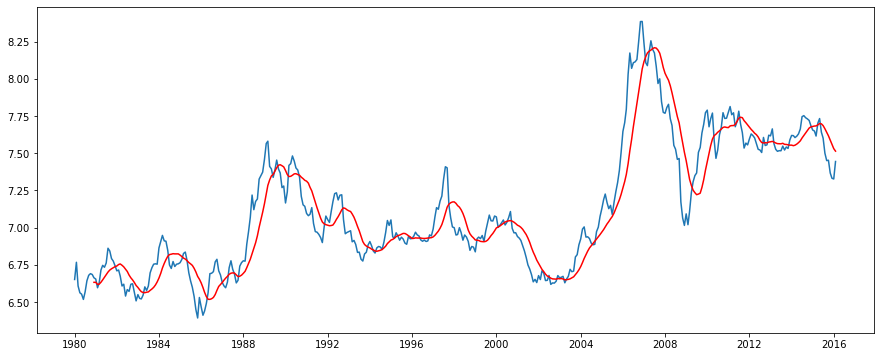

In [10]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [11]:
# Get the difference between the moving average and the actual number of passengers
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)
#Remove Nan Values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Date
1980-12-01    0.030472
1981-01-01    0.021753
1981-02-01   -0.022485
1981-03-01    0.008392
1981-04-01    0.082191
1981-05-01    0.097617
1981-06-01    0.066587
1981-07-01    0.078914
1981-08-01    0.160180
1981-09-01    0.127928
Name: Price, dtype: float64

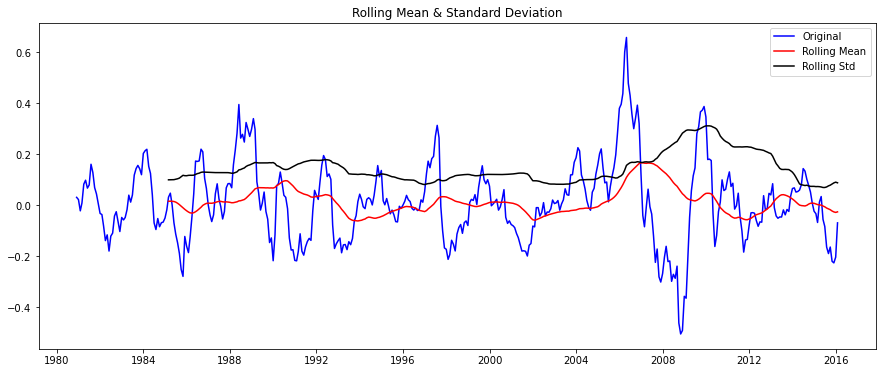

Results of Dickey-Fuller Test:
Test Statistic                -5.898484e+00
p-value                        2.814411e-07
#Lags Used                     4.000000e+00
Number of Observations Used    4.180000e+02
Critical Value (1%)           -3.446091e+00
Critical Value (5%)           -2.868479e+00
Critical Value (10%)          -2.570466e+00
dtype: float64


In [12]:
test_stationarity(ts_log_mv_diff)

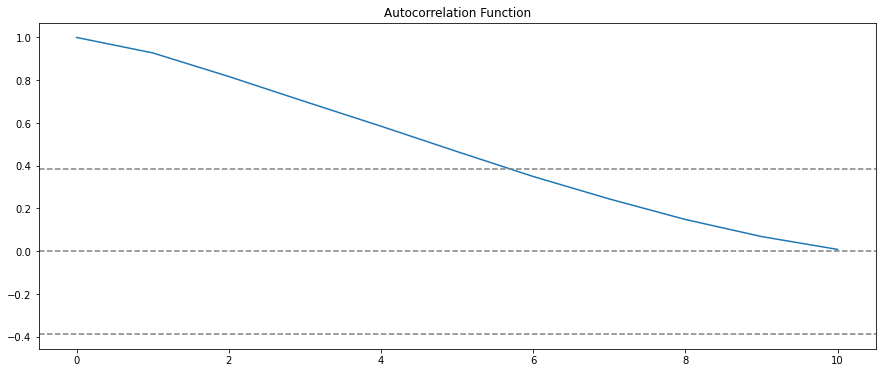

In [13]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

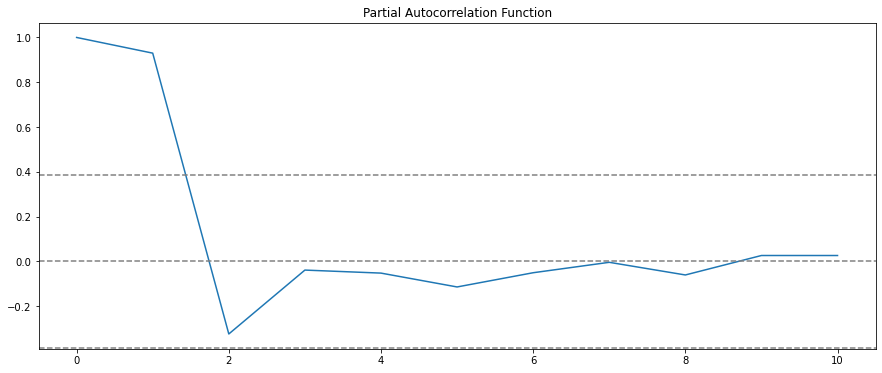

In [14]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

### The PACF curve drops to 0 between lag values 1 and 2. Thus, optimal value of p in the ARIMA model is 1 or 2.

Text(0.5, 1.0, 'RSS: nan')

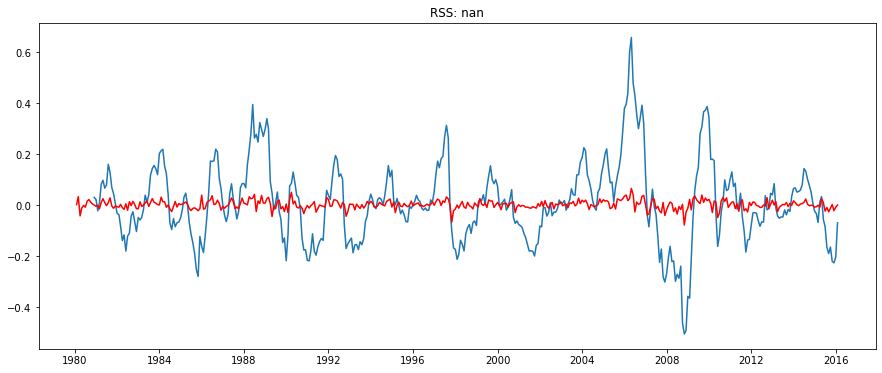

In [15]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [16]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1980-02-01    0.002030
1980-03-01    0.033049
1980-04-01   -0.042031
1980-05-01   -0.011002
1980-06-01   -0.001089
dtype: float64

In [17]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
1980-02-01    0.002030
1980-03-01    0.035079
1980-04-01   -0.006952
1980-05-01   -0.017955
1980-06-01   -0.019043
dtype: float64

# End Of Practice Project